In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузка данных
df = pd.read_csv('C:/Users/aaman/Downloads/heart.csv')

# 1. Удаляем столбцы
df = df.drop(columns=['cp', 'chol', 'fbs', 'exang', 'oldpeak', 'slope', 'ca', 'thal'])

# Сохранение результирующего датасета (если нужно)
df.to_csv('new_data.csv', index=False)

print(df.head())
print(len(df))

   age  sex  trestbps  restecg  thalach  target
0   63    1       145        0      150       1
1   37    1       130        1      187       1
2   41    0       130        0      172       1
3   56    1       120        1      178       1
4   57    0       120        1      163       1
303


Epoch 1, Loss: 1.1055, Accuracy: 0.6557
Epoch 2, Loss: 3.2950, Accuracy: 0.6721
Epoch 3, Loss: 1.5326, Accuracy: 0.7541
Epoch 4, Loss: 1.4182, Accuracy: 0.7377
Epoch 5, Loss: 0.8777, Accuracy: 0.7705
Epoch 6, Loss: 0.6993, Accuracy: 0.7869
Epoch 7, Loss: 0.6599, Accuracy: 0.7869
Epoch 8, Loss: 0.7473, Accuracy: 0.7869
Epoch 9, Loss: 0.7044, Accuracy: 0.7541
Epoch 10, Loss: 0.6798, Accuracy: 0.7869
Epoch 11, Loss: 0.6260, Accuracy: 0.7869
Epoch 12, Loss: 0.6108, Accuracy: 0.8197
Epoch 13, Loss: 0.7148, Accuracy: 0.7869
Epoch 14, Loss: 0.6345, Accuracy: 0.7705
Epoch 15, Loss: 0.6090, Accuracy: 0.7869
Epoch 16, Loss: 0.6672, Accuracy: 0.8033
Epoch 17, Loss: 0.6195, Accuracy: 0.8197
Epoch 18, Loss: 0.6103, Accuracy: 0.8361
Epoch 19, Loss: 0.5856, Accuracy: 0.8197
Epoch 20, Loss: 0.5887, Accuracy: 0.8361
Epoch 21, Loss: 0.5877, Accuracy: 0.8361
Epoch 22, Loss: 0.5901, Accuracy: 0.8361
Epoch 23, Loss: 0.5776, Accuracy: 0.8197
Epoch 24, Loss: 0.5624, Accuracy: 0.8033
Epoch 25, Loss: 0.5809, A

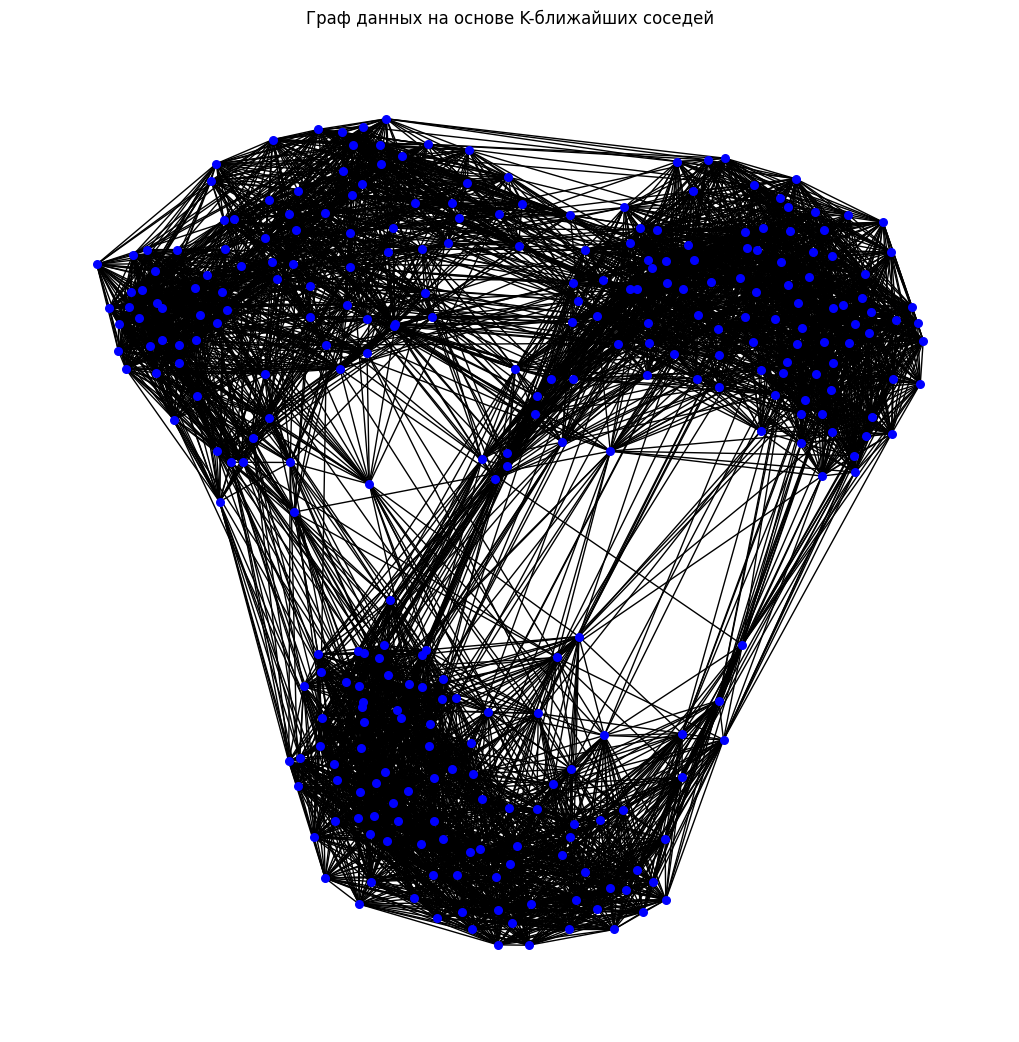

In [54]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, BatchNorm
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN


# 1. Подготовка данных
# Загрузка вашего датасета
df = pd.read_csv('C:/Users/aaman/Downloads/new_data.csv')

# Масштабируем признаки
scaler = StandardScaler()
features = scaler.fit_transform(df.drop(columns=['target']))

# Преобразуем данные в формат PyTorch Geometric
x = torch.tensor(features, dtype=torch.float)  # узлы графа (признаки)
y = torch.tensor(df['target'].values, dtype=torch.long)  # метки классов

# 2. Создание рёбер на основе K-ближайших соседей
k_neighbors = 30
adjacency_matrix = kneighbors_graph(features, k_neighbors, mode='connectivity', include_self=False)
edge_index = torch.tensor(adjacency_matrix.nonzero(), dtype=torch.long)

# Создание объекта данных для графовой нейронной сети
data = Data(x=x, edge_index=edge_index, y=y)

# 3. Разделение данных на обучающие и тестовые
# Определим маски для обучения и тестирования
num_nodes = x.size(0)
perm = np.random.permutation(num_nodes)
train_size = int(0.8 * num_nodes)  # 80% данных на обучение

# Определяем обучающую и тестовую маски
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[perm[:train_size]] = True  # 80% данных - обучение
test_mask[perm[train_size:]] = True  # 20% данных - тестирование

# Добавляем маски в данные
data.train_mask = train_mask
data.test_mask = test_mask

# Определение графовой нейросети на основе GAT
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, concat=True, dropout=0.6)
        self.bn1 = BatchNorm(hidden_channels * 8)
        self.conv2 = GATConv(hidden_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Обучение модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=data.x.size(1), hidden_channels=16, out_channels=2).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

# Функция обучения
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # вычисляем потери
    loss.backward()
    optimizer.step()
    return loss

# Функция тестирования
def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / data.test_mask.sum().item()
    return accuracy

# Основной цикл обучения
for epoch in range(25):
    loss = train()
    acc = test()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')

# 6. Визуализация графа
# Построение графа из рёбер
G = nx.Graph()
G.add_edges_from(edge_index.T.tolist())

# Визуализация графа
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=30, node_color='blue')
plt.title('Граф данных на основе K-ближайших соседей')
plt.show()



In [55]:
print(df['target'].value_counts())


target
1    165
0    138
Name: count, dtype: int64


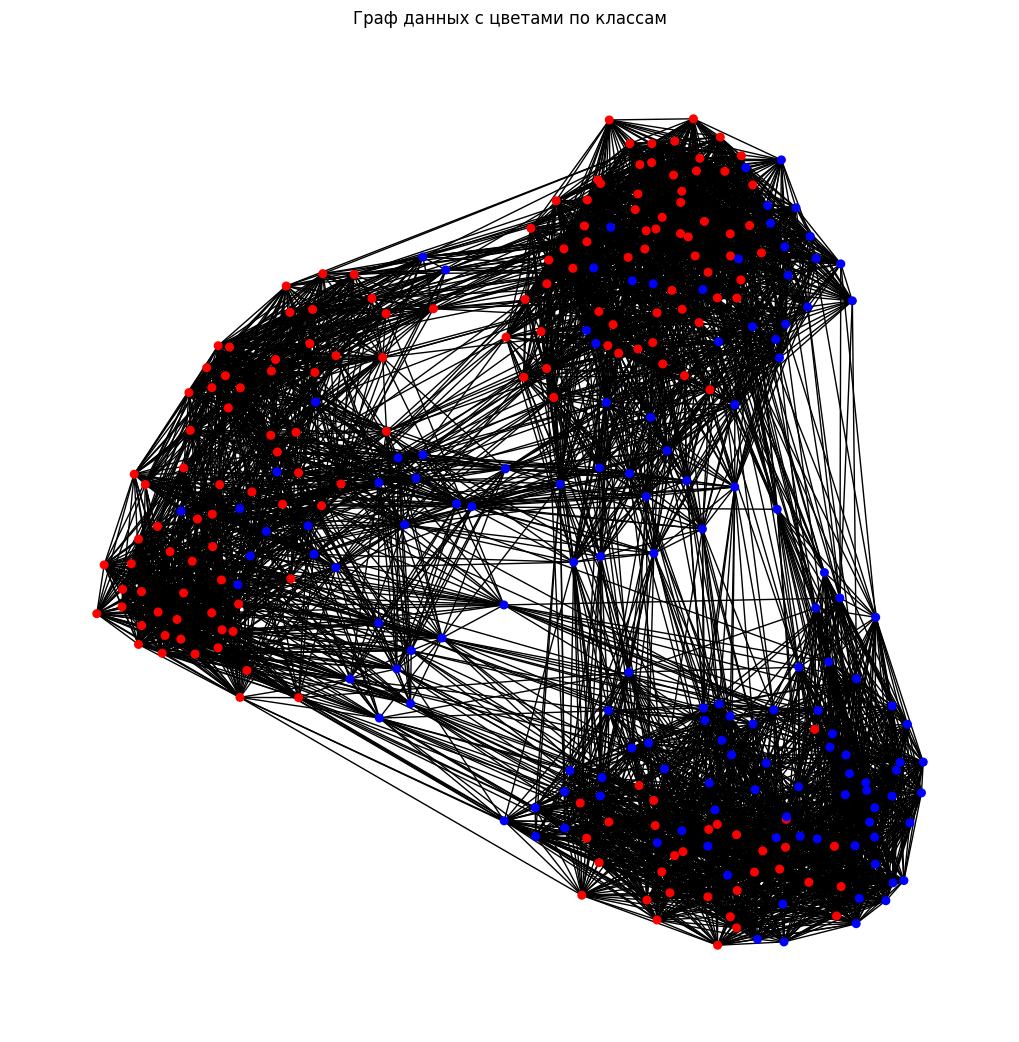

In [56]:
plt.figure(figsize=(10, 10))
node_colors = ['blue' if label == 0 else 'red' for label in df['target']]
nx.draw(G, with_labels=False, node_size=30, node_color=node_colors)
plt.title('Граф данных с цветами по классам')
plt.show()


In [57]:
num_components = nx.number_connected_components(G)
print(f"Количество связанных компонентов: {num_components}")


Количество связанных компонентов: 1


In [58]:
edge_index_numpy = edge_index.numpy()
num_edges_between_classes = sum(1 for i in range(edge_index_numpy.shape[1]) 
                                 if df['target'].iloc[edge_index_numpy[0, i]] != df['target'].iloc[edge_index_numpy[1, i]])
print(f'Количество рёбер между классами: {num_edges_between_classes}')


Количество рёбер между классами: 3523


In [59]:
# Получаем предсказания для всех узлов
model.eval()
out = model(data)
pred_probs = F.softmax(out, dim=1)  # Получаем вероятности
pred_classes = pred_probs.argmax(dim=1)  # Получаем классы

# Получаем узлы с наибольшими вероятностями для каждого класса
top_nodes = {}
for class_index in range(pred_probs.size(1)):
    top_nodes[class_index] = pred_probs[:, class_index].topk(30)  

print("Узлы с наибольшим влиянием:")
for class_index, (values, indices) in top_nodes.items():
    print(f"Класс {class_index}: узлы {indices.tolist()}, вероятности {values.tolist()}")


Узлы с наибольшим влиянием:
Класс 0: узлы [226, 233, 187, 166, 234, 268, 244, 217, 269, 218, 265, 256, 174, 95, 191, 264, 279, 253, 137, 297, 201, 13, 238, 254, 51, 206, 179, 34, 106, 242], вероятности [0.8746500015258789, 0.8724321722984314, 0.8633744120597839, 0.8626009821891785, 0.8612266778945923, 0.8579104542732239, 0.8557955622673035, 0.8550515174865723, 0.8547576069831848, 0.8518215417861938, 0.8450194597244263, 0.8446691036224365, 0.8437111973762512, 0.8432587385177612, 0.8420790433883667, 0.8391299247741699, 0.8388094902038574, 0.833915650844574, 0.8273773193359375, 0.8266575932502747, 0.8264848589897156, 0.826381504535675, 0.8240272998809814, 0.817124605178833, 0.8138461112976074, 0.8122270703315735, 0.8108561038970947, 0.8073722124099731, 0.806178867816925, 0.8031913042068481]
Класс 1: узлы [125, 65, 72, 1, 124, 115, 134, 53, 142, 118, 103, 162, 154, 259, 74, 30, 141, 80, 157, 21, 24, 22, 146, 32, 122, 283, 135, 2, 108, 44], вероятности [0.9976116418838501, 0.996538400650024

In [ ]:
node_names = df['thalach'].values  
# Узлы с наибольшим влиянием
top_nodes = {
    0: [297, 243, 179, 240, 202, 233, 226, 269, 95, 272, 244, 234, 276, 225, 165, 187, 221, 254, 198, 247, 231, 106, 184, 250, 262, 139, 279, 242, 218, 268],
    1: [102, 36, 124, 283, 118, 142, 115, 154, 134, 161, 263, 53, 30, 223, 65, 125, 82, 18, 1, 16, 67, 24, 103, 4, 108, 131, 135, 122, 15, 2]
}

print("Узлы с наибольшим влиянием:")
for class_index, indices in top_nodes.items():
    names = [node_names[i] for i in indices]  # Получаем имена узлов по индексам
    probs = [pred_probs[i].max().item() for i in indices]  # Получаем вероятности
    print(f"Класс {class_index}: узлы {names}, вероятности {probs}")


Узлы с наибольшим влиянием:
Класс 0: узлы [90, 88, 112, 112, 111, 96, 103, 103, 111, 71, 105, 109, 105, 125, 108, 109, 111, 125, 99, 120, 124, 131, 128, 122, 95, 105, 125, 132, 127, 116], вероятности [0.8266575932502747, 0.7538174986839294, 0.8108561038970947, 0.7277523279190063, 0.8031476140022278, 0.8724321722984314, 0.8746500015258789, 0.8547576069831848, 0.8432587385177612, 0.7668953537940979, 0.8557955622673035, 0.8612266778945923, 0.7400211095809937, 0.7550377249717712, 0.7978487610816956, 0.8633744120597839, 0.7342949509620667, 0.817124605178833, 0.7751036286354065, 0.6437620520591736, 0.800475001335144, 0.806178867816925, 0.7150629758834839, 0.727148711681366, 0.7417036890983582, 0.7370117902755737, 0.8388094902038574, 0.8031913042068481, 0.8518215417861938, 0.8579104542732239]
Класс 1: узлы [179, 170, 179, 181, 172, 173, 170, 152, 163, 166, 169, 175, 168, 133, 182, 192, 160, 171, 187, 172, 175, 178, 194, 163, 162, 162, 163, 172, 158, 172], вероятности [0.8100038170814514, 0.85

In [ ]:
from IPython.display import display
# Получаем значения параметров для узлов из класса 0
nodes_class_0 = top_nodes[0]  # Индексы узлов для класса 0
parameters_class_0 = df.iloc[nodes_class_0]  # Получаем соответствующие строки из датафрейма

print("Параметры узлов для класса 0:")
display(parameters_class_0)


Параметры узлов для класса 0:


,age,sex,trestbps,restecg,thalach,target
297,59,1,164,0,90,0
243,57,1,152,1,88,0
179,57,1,150,0,112,0
240,70,1,160,1,112,0
202,58,1,150,0,111,0
233,64,1,120,0,96,0
226,62,1,120,0,103,0
269,56,1,130,0,103,0
95,53,1,142,0,111,1
272,67,1,120,1,71,0


In [ ]:
# Получаем значения параметров для узлов из класса 1
nodes_class_1= top_nodes[1]  # Индексы узлов для класса 1
parameters_class_1 = df.iloc[nodes_class_1]  # Получаем соответствующие строки из датафрейма

print("Параметры узлов для класса 1:")
display(parameters_class_1)


Параметры узлов для класса 1:


,age,sex,trestbps,restecg,thalach,target
102,63,0,140,1,179,1
36,54,0,135,1,170,1
124,39,0,94,1,179,1
283,40,1,152,1,181,0
118,46,0,105,1,172,1
142,42,0,120,1,173,1
115,37,0,120,1,170,1
154,39,0,138,1,152,1
134,41,0,126,1,163,1
161,55,0,132,1,166,1


In [61]:
# Получаем предсказания
model.eval()  # Переводим модель в режим оценки
out = model(data)  # Прогоняем данные через модель
predictions = out.argmax(dim=1)  # Получаем предсказания (индексы классов)


In [62]:
results = pd.DataFrame({
    'Node Index': np.arange(len(predictions)),
    'True Value': df['target'].values,
    'Predicted Value': predictions.cpu().numpy()  # Приводим к numpy и перемещаем на CPU, если необходимо
})

# Выводим результаты
print(results)

     Node Index  True Value  Predicted Value
0             0           1                0
1             1           1                1
2             2           1                1
3             3           1                1
4             4           1                1
..          ...         ...              ...
298         298           0                1
299         299           0                1
300         300           0                0
301         301           0                0
302         302           0                1

[303 rows x 3 columns]


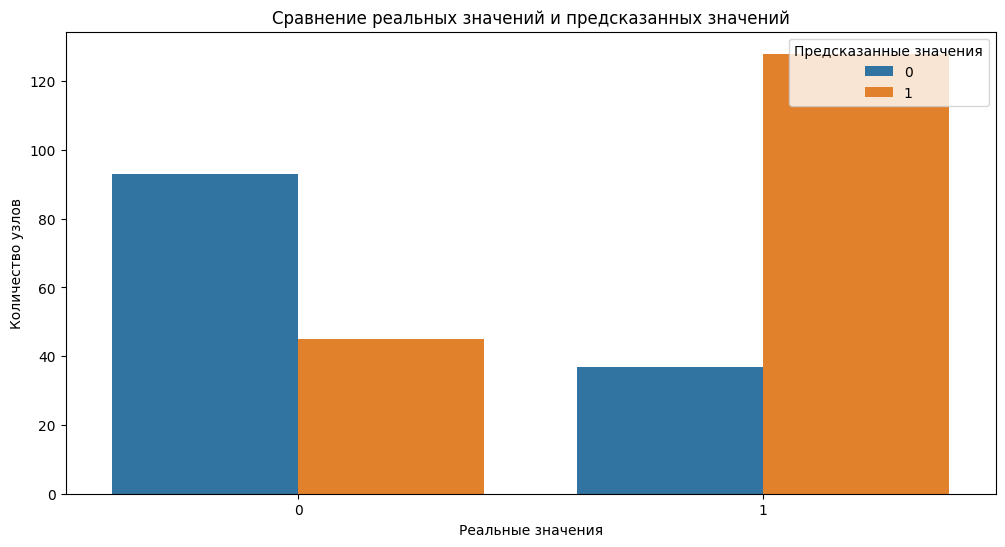

In [63]:
import seaborn as sns

# Визуализация предсказаний
plt.figure(figsize=(12, 6))
sns.countplot(x='True Value', hue='Predicted Value', data=results)
plt.title('Сравнение реальных значений и предсказанных значений')
plt.xlabel('Реальные значения')
plt.ylabel('Количество узлов')
plt.legend(title='Предсказанные значения', loc='upper right')
plt.show()

In [ ]:

data = pd.read_excel('C:/Users/aaman/OneDrive/Рабочий стол/da.xlsx', sheet_name='Sheet1')
data.head()


,Больные,age,sex,trestbps,restecg,thalach,target,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Здоровые,age.1,sex.1,trestbps.1,restecg.1,thalach.1,target.1
0,102,63,0,140,1,179,1,NaN,NaN,NaN,NaN,297,59,1,164,0,90,0
1,36,54,0,135,1,170,1,NaN,NaN,NaN,NaN,243,57,1,152,1,88,0
2,124,39,0,94,1,179,1,NaN,NaN,NaN,NaN,179,57,1,150,0,112,0
3,283,40,1,152,1,181,0,NaN,NaN,NaN,NaN,240,70,1,160,1,112,0
4,118,46,0,105,1,172,1,NaN,NaN,NaN,NaN,202,58,1,150,0,111,0


In [40]:
# Определим общие параметры между больными и здоровыми для сравнения
common_columns = ['age', 'sex', 'trestbps', 'restecg', 'thalach', 'target']

# Извлечем данные по больным и здоровым для этих параметров
sick_data = data[common_columns]
healthy_data = data[[col + '.1' for col in common_columns]].rename(columns=lambda x: x.replace('.1', ''))

# Рассчитаем разницы для каждого параметра по отдельности
differences = sick_data.mean() - healthy_data.mean()
differences


age        -13.900000
sex         -0.833333
trestbps   -14.466667
restecg      0.500000
thalach     59.833333
target       0.800000
dtype: float64

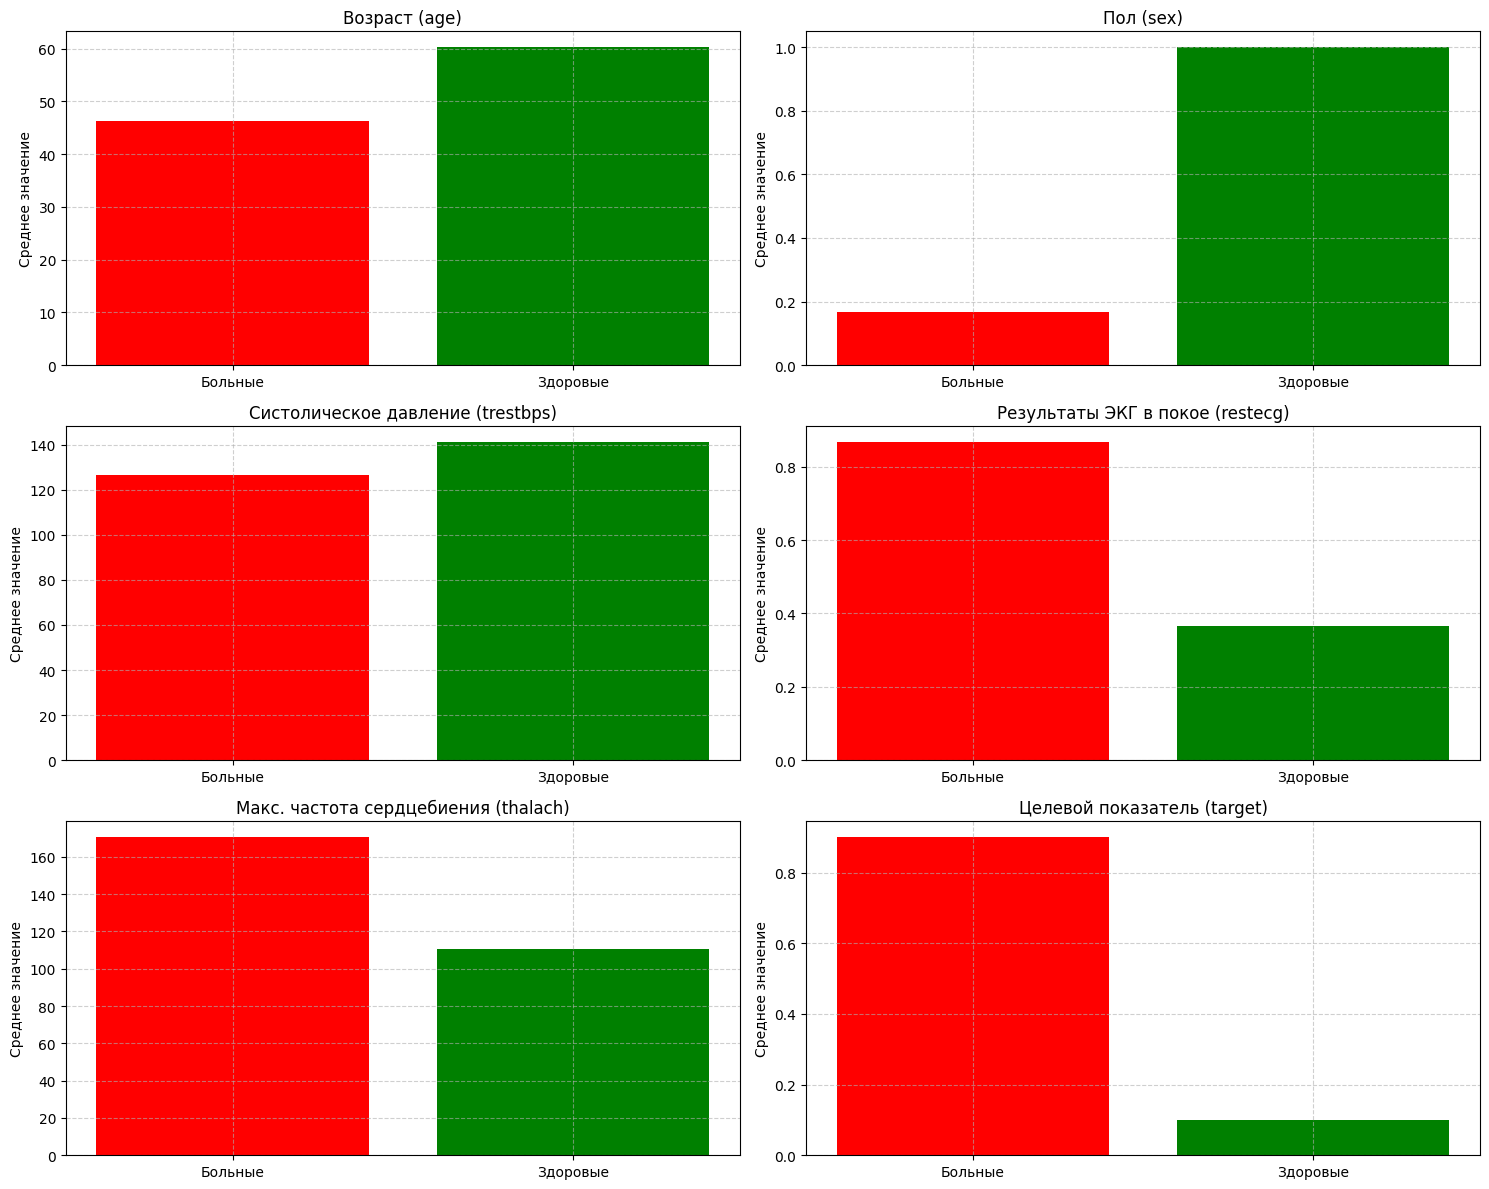

In [ ]:
import matplotlib.pyplot as plt

# Построим графики для каждой метрики
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()


metrics = differences.index
titles = [
    "Возраст (age)",
    "Пол (sex)",
    "Систолическое давление (trestbps)",
    "Результаты ЭКГ в покое (restecg)",
    "Макс. частота сердцебиения (thalach)",
    "Целевой показатель (target)"
]

# Построим столбчатые диаграммы
for i, metric in enumerate(metrics):
    axes[i].bar(['Больные', 'Здоровые'], [sick_data[metric].mean(), healthy_data[metric].mean()], color=['red', 'green'])
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('Среднее значение')
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
